In [50]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches as patches
import random
import pandas as pd

img_color = cv2.imread("a_girl_with_a_flower_in_her_hair_1939.1.108.jpg",1)
img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)

height = img_gray.shape[0]
width = img_gray.shape[1]


In [54]:
class Rectangle:
    def __init__(self, x_min, y_min, y_max, x_max, h, w, r, g, b):
        self.x_min = x_min
        self.y_min = y_min
        self.y_max = y_max
        self.x_max = x_max
        self.h = h
        self.w = w
        self.r = r
        self.g = g
        self.b = b

In [ ]:
# clahe histogramm

clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(100,100))
cl1 = clahe.apply(img_gray)

fig = plt.figure()
fig.set_size_inches(20,20)
ax = fig.add_subplot(1,3,1)
plt.imshow(cl1)

blurred = cv2.GaussianBlur(cl1, (11, 11), 0)
ax = fig.add_subplot(1,3,2)
plt.imshow(blurred)

# canny edge detection
edges_img = cv2.Canny(cl1, 170, 350, apertureSize=3, L2gradient=True)
# 150/350
ax = fig.add_subplot(1,3,3)
plt.imshow(edges_img)

In [58]:
indices = np.where(edges_img != [0])
edge_coordinates = list(zip(indices[1], indices[0]))
edges_df = pd.DataFrame(edge_coordinates, columns=("x", "y"))

In [62]:
# split rectangle in 1,2 or 3 parts
choices = [1, 2, 3]
weights = (0.0, 0.25, 0.75)

def split_rectangle(rectangle, direction, divisions):

    new_rectangles = []
    height = rectangle[2]
    width = rectangle[3]
    x_s = rectangle[0]
    y_s = rectangle[1]
    y_e = y_s + height
    x_e = x_s + width

    if divisions != 3:
        if direction == 0:
            for i in range(divisions):
                inc = round((y_e - y_s)/(divisions-i))
                new_rectangles.append([x_s, y_s, inc, width])
                y_s = y_s + inc 
        elif direction == 1:
            for i in range(divisions):
                inc = round((x_e - x_s)/(divisions-i))
                new_rectangles.append([x_s, y_s, height, inc])
                x_s = x_s + inc
    else:
        sub_divs = random.choices([2, 3], cum_weights=(0.3, 0.7), k=1)[0]
        if sub_divs == 2:
            l_or_r = random.choices([0, 1], cum_weights=(0.5, 1.0), k=1)[0]
            if l_or_r == 0:
                if direction == 0:
                    inc = round((y_e - y_s)/3)
                    new_rectangles.append([x_s, y_s, inc, width])
                    y_s = y_s + inc
                    new_rectangles.append([x_s, y_s, height-inc, width])
                elif direction == 1:
                    inc = round((x_e - x_s)/3)
                    new_rectangles.append([x_s, y_s, height, inc])
                    x_s = x_s + inc       
                    new_rectangles.append([x_s, y_s, height, width-inc])
            if l_or_r == 1:
                if direction == 0:
                    inc = round((y_e - y_s)/3*2)
                    new_rectangles.append([x_s, y_s, inc, width])
                    y_s = y_s + inc
                    new_rectangles.append([x_s, y_s, height-inc, width])
                elif direction == 1:
                    inc = round((x_e - x_s)/3*2)
                    new_rectangles.append([x_s, y_s, height, inc])
                    x_s = x_s + inc       
                    new_rectangles.append([x_s, y_s, height, width-inc])
        if sub_divs == 3:
            if direction == 0:
                for i in range(divisions):
                    inc = round((y_e - y_s)/(divisions-i))
                    new_rectangles.append([x_s, y_s, inc, width])
                    y_s = y_s + inc
            elif direction == 1:
                for i in range(divisions):
                    inc = round((x_e - x_s)/(divisions-i))
                    new_rectangles.append([x_s, y_s, height, inc])
                    x_s = x_s + inc

    return new_rectangles

def points_in_rectangle(rect,points):
    points_x = points[points['x'].between(rect[0], rect[0]+rect[3])]
    points_y = points_x[points_x['y'].between(rect[1], rect[1]+rect[2])]
    if points_y.shape[0] > 2:
        return True
    else:
        return False

# start rectangle    
rect = [0, 0, img_color.shape[0], img_color.shape[1]]
edges = pd.DataFrame(edge_coordinates[::1], columns=['x','y'])

rect_list = [rect]

for i in range(12):
    new_rect_list = []
    for rectangle in rect_list:
        if rect[2] > 4 and rect[3] > 4:
            if points_in_rectangle(rectangle, edges):
                number_of_divisions = random.choices(choices, cum_weights=weights, k=1)[0]
                new_rect_list.extend(split_rectangle(rectangle,i%2,number_of_divisions))
            else:
                number_of_divisions = 1
                new_rect_list.extend(split_rectangle(rectangle,i%2,number_of_divisions))
            
    rect_list = new_rect_list


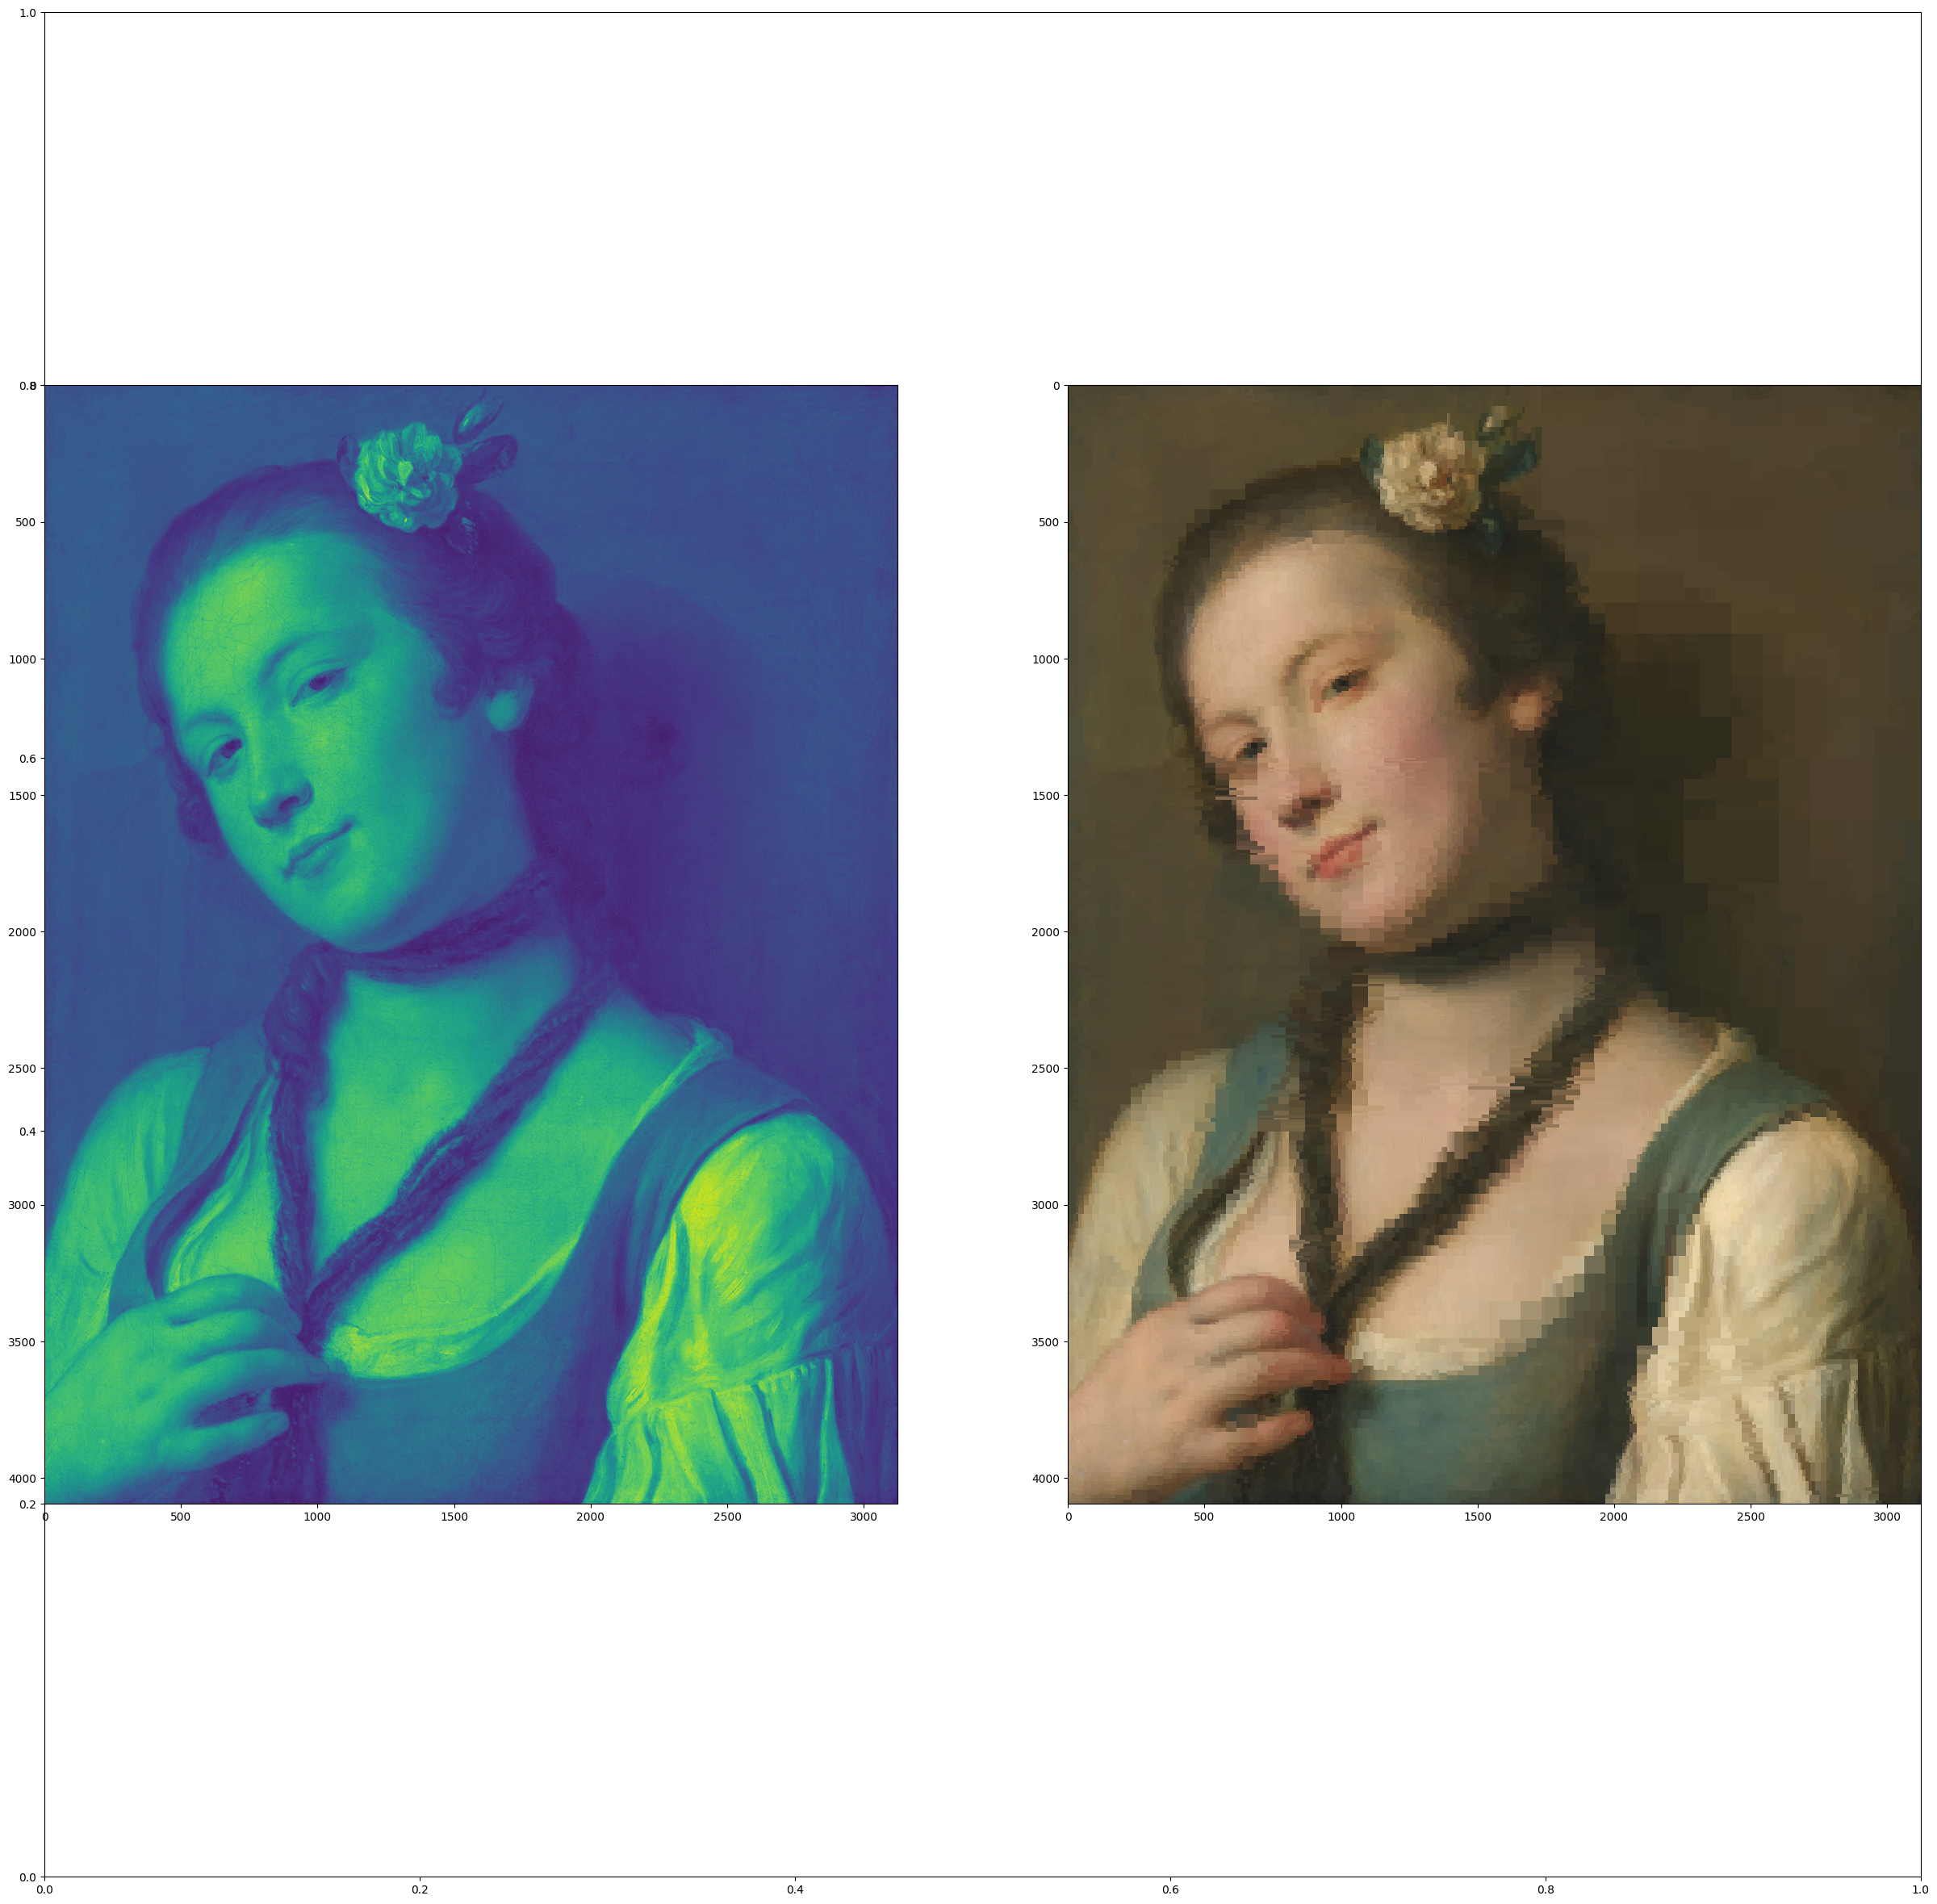

In [63]:
fig, ax = plt.subplots()
fig.set_size_inches(30,30)
ax = fig.add_subplot(1,2,1)
plt.imshow(img_gray)

output = []
# draw first rectangle 
ax = fig.add_subplot(1,2,2)
plt.imshow(edges_img)
for rect in rect_list:
    img_small = img_color[rect[1]:rect[1]+rect[2], rect[0]:rect[0]+rect[3]]
    col = img_small.mean(axis=0).mean(axis=0)
    # converte color to RGB
    col = col[::-1]
    tmp = Rectangle(x_min=rect[0], y_min=rect[1],
                   y_max=rect[1]+rect[2],x_max=rect[0]+rect[3],
                   h=rect[2], w=rect[3],
                   r=col[0]/255,g=col[1]/255,b=col[2]/255)
    output.append(tmp)
    # draw rectangles on image
    rect_1 = patches.Rectangle((rect[0], rect[1]), rect[3], rect[2], linewidth=1, edgecolor=(0,0,0,0), facecolor=col/255)
    ax.add_artist(rect_1)
    
import dill as pickle

with open('flowers.pkl', 'wb') as file:
    pickle.dump(output, file)    

In [56]:
# fist rectangle ROI
img_small = img_color[rect_end_pixel[0]:rect_end_pixel[1], 0:width]  
# mean color of first rectangle (GBR)
col = img_small.mean(axis=0).mean(axis=0)
# converte color to RGB
col = col[::-1]


# find dominant color
pixels = np.float32(img_small.reshape(-1, 3))

n_colors = 5
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, .1)
flags = cv2.KMEANS_RANDOM_CENTERS

_, labels, palette = cv2.kmeans(pixels, n_colors, None, criteria, 10, flags)
_, counts = np.unique(labels, return_counts=True)
dominant = palette[np.argmax(counts)]
dominant = dominant[::-1]
print(dominant)

NameError: name 'rect_end_pixel' is not defined